<a href="https://colab.research.google.com/github/morteza/notebooks/blob/master/tfp_keras_embedding_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow_probability as tfp

tfd = tfp.distributions

# Data
n_samples = 10000
n_labels = 64
n_topics = 12
n_categories = 2


data = pd.DataFrame({
    'category': np.random.choice(n_categories, (n_samples,)),
    'label': np.random.choice(n_labels, (n_samples,)),
})

features = stats.truncnorm(0,1).rvs(size=(n_samples, n_topics))

data = pd.concat([data, pd.DataFrame(features)], axis=1)

data.tail()


category  label         0  ...         9        10        11
9995         0     29  0.338359  ...  0.026990  0.553567  0.579650
9996         0     48  0.733919  ...  0.269333  0.232070  0.141412
9997         1     13  0.382530  ...  0.164159  0.239871  0.142832
9998         1      1  0.192772  ...  0.558733  0.274848  0.120094
9999         1     29  0.570087  ...  0.957332  0.215921  0.497364

[5 rows x 14 columns]

In [2]:
train_dataset = data.sample(frac=.8, random_state=0)
test_dataset = data.drop(train_dataset.index)

In [4]:
Root = tfd.JointDistributionCoroutine.Root  # alias.

# Model
def model():

  rv_cat = yield Root(tfd.Categorical(tf.ones(n_categories)/n_categories, name='category'))

  cat_to_lbl = tf.stack([
      tf.constant(np.ones(n_labels, dtype='float32')),
      tf.constant(np.ones(n_labels, dtype='float32'))      
  ])[rv_cat,]

  rv_lbl = yield tfd.Categorical(cat_to_lbl, name='label')
  lbl_to_prb = tf.constant(np.ones(n_labels, dtype='float32'))[rv_lbl]
  
  rv_prb = yield tfd.HalfNormal(lbl_to_prb, name='prob')

joint = tfd.JointDistributionCoroutineAutoBatched(model)

x = joint.sample(100)
x
# joint.prob(**x._asdict())

StructTuple(
  category=<tf.Tensor: shape=(100,), dtype=int32, numpy=
    array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
           1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
           0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
           0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
           1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int32)>,
  label=<tf.Tensor: shape=(100,), dtype=int32, numpy=
    array([43, 55,  2, 50, 42,  0, 34, 14, 24, 47, 61, 62, 29,  3, 14,  8, 17,
           54, 24, 14, 51,  5, 11,  5, 26,  8, 12, 54, 36, 56, 63, 36, 29, 10,
           25, 42, 40, 48, 49, 23, 37, 27, 37, 22, 44, 58, 11, 21, 29, 27,  2,
           33, 17, 33, 51, 53, 29, 10, 38, 18, 52, 31, 39, 29, 23, 52,  8, 57,
           37, 62, 49, 31, 40, 56, 59,  8,  4, 28, 34, 60, 36, 62,  5,  6, 53,
            3, 33, 25,  9, 25, 48,  0, 61, 55, 12, 12, 60,  6, 25, 21],
          dtype=int32)>,
  prob=<tf.Te

In [6]:
X = data['label'].astype('category').cat.codes.values
y = data.drop(columns=['category','label'])

model = tf.keras.Sequential()
model.add(layers.Embedding(n_labels, n_topics))
model.compile('adam', 'mse')
history = model.fit(X, y, epochs=5)
y_pred = model.predict(data['label'])
z = model.get_layer(index=0).get_weights()[0]

Epoch 1/5
313/313 [==============================] - 1s 1ms/step - loss: 0.2228
Epoch 2/5
313/313 [==============================] - 0s 2ms/step - loss: 0.1344
Epoch 3/5
313/313 [==============================] - 0s 1ms/step - loss: 0.0965
Epoch 4/5
313/313 [==============================] - 0s 1ms/step - loss: 0.0838
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.0805


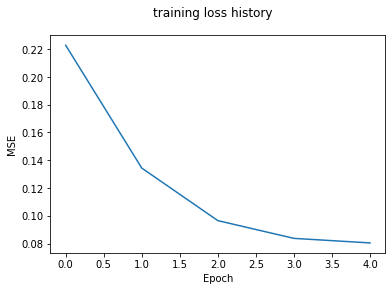

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(np.arange(len(history.history['loss'])), history.history['loss'])
plt.suptitle('training loss history')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()